In [2]:
import os
import re
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

torch.manual_seed(1)

In [132]:
#Let's get the data
def load_data(path="../data/poetryFromTang.txt", length=5000):
    df = pd.read_csv(path, names=["_"])[:length].values
    from itertools import chain
    s = sum(df, [])
    return ''.join(list(zip(*df))[0])

x = load_data("../data/poetryFromTang.txt")

print(x[:50])

def clean_text(x):
  x = [re.sub(r'[。， ]+', '',i) for i in x]
  x = [i for i in x if i]
  return x

x = clean_text(x)

print(x[:50])

#x_train, x_val= train_test_split(x, test_size=0.2)

print(len(x))

巴山上峡重复重，阳台碧峭十二峰。荆王猎时逢暮雨，夜卧高丘梦神女。轻红流烟湿艳姿，行云飞去明星稀。目极
['巴', '山', '上', '峡', '重', '复', '重', '阳', '台', '碧', '峭', '十', '二', '峰', '荆', '王', '猎', '时', '逢', '暮', '雨', '夜', '卧', '高', '丘', '梦', '神', '女', '轻', '红', '流', '烟', '湿', '艳', '姿', '行', '云', '飞', '去', '明', '星', '稀', '目', '极', '魂', '断', '望', '不', '见', '猿']
13324


In [133]:
#Simple Dict for embedding
def build_dict(x):
    ret = []
    for i in x:
        ret += [j for j in i.split()]
    return list(set(ret))

d = build_dict(x)

word2idx = {d[i]:i for i in range(len(d))}

pad_idx = len(word2idx)

word2idx["<EOS>"] = pad_idx

idx2word = {word2idx[key]:key for key in word2idx.keys()}

vocab_size = len(word2idx)

n_classes = 5

print("vocab_size: ", vocab_size)


vocab_size:  2510


In [134]:
def get_dataset(x):
    return [word2idx[i] for i in x]
    
dataset = get_dataset(x)

print(dataset[:50])

[926, 415, 1628, 797, 2215, 1466, 2215, 203, 1170, 1328, 2110, 1572, 1698, 1479, 726, 1540, 434, 1182, 1561, 1935, 2106, 1989, 1459, 217, 2441, 419, 2350, 739, 2370, 819, 1141, 2496, 1224, 631, 270, 1820, 1251, 2270, 32, 2435, 1295, 864, 57, 1283, 1577, 479, 1259, 1917, 1617, 261]


In [135]:
class LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super().__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        self.fc = nn.Linear(embedding_dim, vocab_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        out = F.log_softmax(self.fc(lstm_out.view(len(sentence), -1)), dim=1)
        return out
    
    def predict(self, start, max_length=max_length):
        x = self.word_embeddings(start).unsqueeze(0).view(1, 1, -1)

        hidden = (torch.zeros(1, 1, net.hidden_dim), torch.zeros(1, 1, net.hidden_dim))
        from copy import copy
        lstm_out = copy(x)

        for i in range(max_length-1):
            x, hidden = net.lstm(x, hidden)
            lstm_out = torch.cat([lstm_out, x])

        out = F.log_softmax(net.fc(lstm_out.view(max_length, -1)), dim=1)

        print(out.shape)

        out = torch.argmax(out,dim=1)

        print(out)

        return out.tolist()


In [136]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 100
max_length = 14
net = LSTM(embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, vocab_size=vocab_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

loss_list = []

for epoch in range(20):
    i = 0
    current_loss = 0
    while i + max_length < len(dataset):
        net.zero_grad()

        sentence_in, targets = torch.tensor(dataset[i:i+max_length]), torch.tensor(dataset[i+1:i+1+max_length])

        predicts = net(sentence_in)

        loss = criterion(predicts, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

        loss_list.append(loss.item())

        i += max_length

    print("epoch: ", epoch, "current_loss: ", current_loss)




epoch:  0 current_loss:  7182.709280014038
epoch:  1 current_loss:  6250.969700336456
epoch:  2 current_loss:  5358.760045051575
epoch:  3 current_loss:  4490.325328826904
epoch:  4 current_loss:  3759.0927052497864
epoch:  5 current_loss:  3247.3799164295197
epoch:  6 current_loss:  2834.7041536569595
epoch:  7 current_loss:  2519.793232500553
epoch:  8 current_loss:  2283.2843888401985
epoch:  9 current_loss:  2120.4459524452686
epoch:  10 current_loss:  1954.8651687800884
epoch:  11 current_loss:  1817.0933242589235
epoch:  12 current_loss:  1710.9572068303823
epoch:  13 current_loss:  1624.03026548028
epoch:  14 current_loss:  1562.7735274881124
epoch:  15 current_loss:  1469.773981899023
epoch:  16 current_loss:  1464.8717890828848
epoch:  17 current_loss:  1408.0242511183023
epoch:  18 current_loss:  1326.3597556501627
epoch:  19 current_loss:  1308.0769902467728


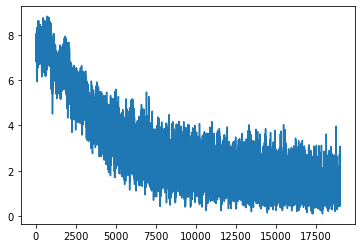

In [137]:
plt.plot(loss_list)
plt.show()

In [138]:
def generate(start="春", max_length=max_length):

    x = torch.tensor(word2idx[start])

    predicts = net.predict(x, max_length)

    #predicts = predict(net, x, max_length)

    sentence = [idx2word[i] for i in predicts]

    print(sentence)


generate()

torch.Size([14, 2510])
tensor([1095,  980,   98,   95,  661,  777, 1795, 2283, 2283,  285,  285, 2330,
        1919, 1917])
['应', '风', '未', '满', '数', '取', '公', '归', '归', '一', '一', '露', '厚', '不']
